# 訓練データの対称性関数の値とスパッタリングシミュレーション中の対称性関数の値を比較する
1. 訓練データの対称性関数の値をSymmetryFunctionValueReaderで取得する
2. 取得した値で次元圧縮器の訓練を行う
3. スパッタリングシミュレーションの軌跡に対して同様に対称性関数を計算する
4. 得られた対称性関数の値を２で訓練された次元圧縮器に入力し、次元圧縮を行う
5. 2と4で得られた次元圧縮後の値を比較し、4で外れている原子がある場合はその周りの構造を取得する
6. 5で得られた構造を訓練データに入れてスパッタリングシミュレーションを行う
7. 実験値に近づいていくかどうか確認する
8. 1~7を繰り返す

In [1]:
from mlptools.analyzer.symmetry_function import SymmetryFunctionValueReader
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from glob import glob

1. 訓練データの対称性関数の値をSymmetryFunctionValueReaderで取得する

In [2]:
path2target = "/Users/y1u0d2/Google Drive/マイドライブ/HamaLab_kotani/n2p2/Si/100/06"

atom_num_symbol_map = {
    14: "Si",
    # 8: "O"
}
sf_reader = SymmetryFunctionValueReader(path2target)
sf_df_dict = sf_reader.read(
    atom_num_symbol_map=atom_num_symbol_map,
    number_of_sf_per_atom=30
)
sf_df_train = sf_df_dict["Si"]

All files exist
Si symmetry function columns are created
Symmetry function dataframe of Si is created


2. 取得した値で次元圧縮器の訓練を行う<br>
変数同士の次元は揃っているのでScalingは必要ない気がするが、念の為StandardScalerを用いたscalingを行う

In [3]:
scaler = StandardScaler()
scaler = scaler.fit(sf_df_train)
sf_df_train_scaled = scaler.transform(sf_df_train)

pca = PCA(n_components=2)
pca.fit(sf_df_train_scaled)

compressed_sf_train = pca.transform(sf_df_train_scaled)

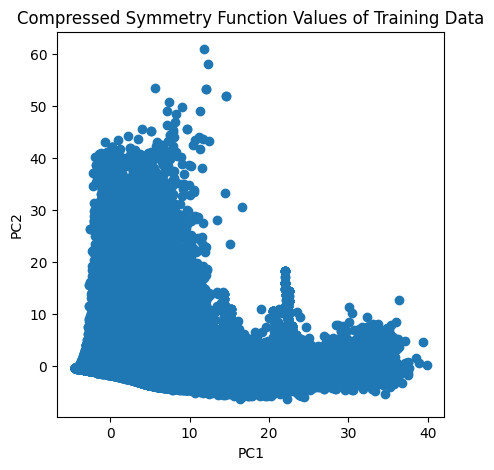

In [4]:
# 2次元で可視化する
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(compressed_sf_train[:, 0], compressed_sf_train[:, 1])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Compressed Symmetry Function Values of Training Data")
plt.show()

3. スパッタリングシミュレーションの軌跡に対して同様に対称性関数を計算する

In [5]:
path2lmp_data = "/Users/y1u0d2/Google Drive/マイドライブ/HamaLab_kotani/sputtering/Si/ml/model_26/data_files"
lmp_data_file_list = glob(os.path.join(path2lmp_data, "data.Si.*"))
print(f"Number of data files: {len(lmp_data_file_list)}")

Number of data files: 1600


In [6]:
# LAMMPSのdataファイルをASE.Atomsで読み込みn2p2の入力へ変換する
from ase.io import read

target_data = lmp_data_file_list[0]
ase_atoms = read(target_data, format="lammps-data")

In [8]:
from mlptools.io.read import read_from_format

mlp_atoms = read_from_format(ase_atoms=ase_atoms, format="ase")

RuntimeError: Atoms object has no calculator.